In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import torch.optim as optim
from tqdm import tqdm
import scipy.io as sio
import hdf5storage
from scipy import stats
from scipy.stats import rankdata
from skimage.transform import resize
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from scipy.ndimage import label, sum as ndi_sum
from scipy.ndimage import zoom
import matplotlib.image
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib import colors
from PIL import Image
import seaborn as sns
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import math

# V4 digital twin raw data

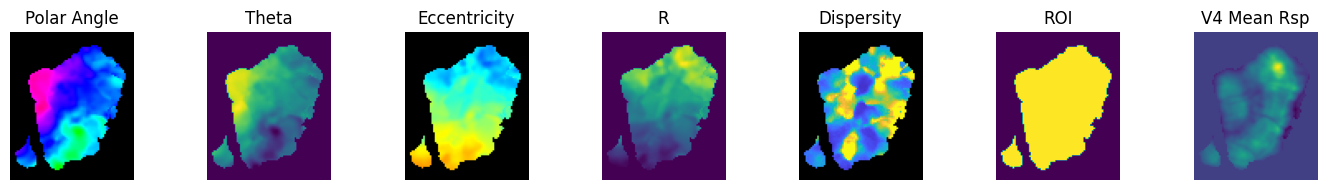

In [21]:
# Load the Dispersity results
dispersity = sio.loadmat("/Users/dunhan/Desktop/topoV4/Tianye/Dispersity_results/dispersity.mat")['cmap'] # (128, 128, 3) <class 'numpy.ndarray'>

# Load the roi for visual inspection: Transpose is super crucial! ############################
roi = np.load("/Users/dunhan/Desktop/topoV4/Tianye/Analysis/S4_preference_map/ROI.npy").T # (128, 128) <class 'numpy.ndarray'>

# Load the RF results
polar_angle = sio.loadmat("/Users/dunhan/Desktop/topoV4/Tianye/RF_results/polar_angle.mat")['map'] # (128, 128, 3) <class 'numpy.ndarray'>
# theta_map_raw: [0.0 60.1088362]; mean=31.2365; std=13.07726
theta = sio.loadmat("/Users/dunhan/Desktop/topoV4/Tianye/RF_results/theta_map_raw.mat")['theta_map_raw'] # (128, 128); or theta_map.mat['theta_map'] after color coding
eccentricity = sio.loadmat("/Users/dunhan/Desktop/topoV4/Tianye/RF_results/eccentricity.mat")['map'] # (128, 128, 3) <class 'numpy.ndarray'>
# r_map_raw: [12.7849 36.81318]; mean=24.77; std=5.7943; # r_map: [233, 767]; mean=501; std=129
r = sio.loadmat("/Users/dunhan/Desktop/topoV4/Tianye/RF_results/r_map_raw.mat")['r_map_raw'] # (128, 128); or r_map.mat['r_map'] after color coding
r[roi!=0] -= np.min(r[roi!=0]) # adjusted r_map_raw: [0, 24.0283]; mean=11.985257; std=5.7943

# Load the V4 digital twin responses to 50k images
response = np.load("/Users/dunhan/Desktop/topoV4/Tianye/Analysis/S4_preference_map/Prsp.npy")
mean_rsp = np.zeros((128, 128))
for i in range(128):
    for j in range(128):
        mean_rsp[i, j] = np.mean(response[:, i, j])
# del response

# visualize the results
fig, axes = plt.subplots(1, 7, figsize=(14, 2))
axes[0].imshow(np.flip(polar_angle, axis=(0, 1))[30:120, 35:110, :])
axes[0].axis('off')  # Turn off the axis
axes[0].set_title('Polar Angle')
axes[1].imshow(np.flip(theta)[30:120, 35:110])
axes[1].axis('off')  # Turn off the axis
axes[1].set_title('Theta')
axes[2].imshow(np.flip(eccentricity, axis=(0, 1))[30:120, 35:110, :])
axes[2].axis('off')  # Turn off the axis
axes[2].set_title('Eccentricity')
axes[3].imshow(np.flip(r)[30:120, 35:110])
axes[3].axis('off')  # Turn off the axis
axes[3].set_title('R')
axes[4].imshow(np.flip(dispersity, axis=(0, 1))[30:120, 35:110, :])
axes[4].axis('off')  # Turn off the axis
axes[4].set_title('Dispersity')
axes[5].imshow(np.flip(roi)[30:120, 35:110])
axes[5].axis('off')  # Turn off the axis
axes[5].set_title('ROI')
axes[6].imshow(np.flip(mean_rsp)[30:120, 35:110])
axes[6].axis('off')  # Turn off the axis
axes[6].set_title('V4 Mean Rsp')
plt.tight_layout()
# plt.savefig("/Users/dunhan/Desktop/topoV4/som/V4_benchmark/digital_twin_heatmaps.png")
plt.show()

In [22]:
theta = theta[np.where(roi!=0)]
r = r[np.where(roi!=0)]
print(np.shape(theta), np.shape(r))
print("polar angle range:", np.min(theta), np.max(theta))
print("eccentricity range:", np.min(r), np.max(r))

(3048,) (3048,)
polar angle range: 0.0 60.10883624961076
eccentricity range: 0.0 24.028273811974355


# Assign V4 neuronal column onto simulated map grid

In [6]:
v4idx = np.load("/Users/dunhan/Desktop/topoV4/som/V4_benchmark/idx.npy") # (128, 128), perserved only with 16 domains of 2875 neuronal columns, not the full 3048 neuronal columns
roi = np.load("/Users/dunhan/Desktop/topoV4/Tianye/Analysis/S4_preference_map/ROI.npy").T # (128, 128), of which 3048 neuronal columns are rois
selected = np.zeros((np.sum(v4idx != 0))) # (2875,)
selected_ij = np.zeros((int(np.sum(v4idx != 0)), 2)) # (2875, 2)
index_selected = 0
index_roi = 0
for i in range(128):
    for j in range(128):
        if roi[i, j] != 0:
            if v4idx[i, j] != 0:
                selected[index_selected] = index_roi
                selected_ij[index_selected, 0] = i
                selected_ij[index_selected, 1] = j
                index_selected += 1
            index_roi += 1
assert index_selected == 2875
assert index_roi == 3048

# given a matched som grid corresponding domain number, remove the unconnected components smaller than a threshold
def connected_components(matched, threshold, return_largest=False):
    # Define the structure (connectivity) for connected components
    structure = np.ones((3, 3), dtype=int)  # 8-connectivity, meaning that both adjacent and diagonal pixels are considered as neighbors
    connected = np.copy(matched) # Initialize an array to store the output
    if return_largest: largest = np.copy(matched) # Initialize an array to store the largest connected component
    for class_num in np.unique(matched): # Process each class separately
        if class_num == 0: continue # Skip the background
        class_mask = (matched == class_num) # Create a binary mask for the current class
        labeled_array, num_features = label(class_mask, structure=structure) # Find connected components in the binary mask
        component_sizes = ndi_sum(class_mask, labeled_array, index=range(1, num_features + 1)) # Compute the size of each component
        for i, size in enumerate(component_sizes): # Zero out components smaller than the threshold
            if size < threshold: connected[labeled_array == (i + 1)] = 0
        if return_largest:
            for i, size in enumerate(component_sizes):
                if size != np.max(component_sizes): largest[labeled_array == (i + 1)] = 0
    if return_largest: return connected, largest
    else: return connected


name = "som16e_250tr_05t"
correlation = np.load("/Users/dunhan/Desktop/topoV4/som/weight_as_units/" + name + "/assign_rsom.npy") # (60, 60, 3048)
correlation = correlation[:, :, selected.astype(int)] # (60, 60, 2875)
matched_idx_rsom = np.zeros((60, 60))
polar_angle_rsom = np.zeros((60, 60, 3))
eccentricity_rsom = np.zeros((60, 60, 3))
dispersity_rsom = np.zeros((60, 60, 3))
for i in range(60):
    for j in range(60):
        k = np.argmax(correlation[i, j, :]) # index of the entry with the maximum correlation
        x = int(selected_ij[k, 0])
        y = int(selected_ij[k, 1])
        matched_idx_rsom[i, j] = v4idx[x, y]
        polar_angle_rsom[i, j, :] = polar_angle[x, y, :]
        eccentricity_rsom[i, j, :] = eccentricity[x, y, :]
        dispersity_rsom[i, j, :] = dispersity[x, y, :]
np.save("/Users/dunhan/Desktop/topoV4/som/weight_as_units/" + name + "/idx_newassign.npy", matched_idx_rsom)

name = "som16e"
correlation = np.load("/Users/dunhan/Desktop/topoV4/som/weight_as_units/" + name + "/assign_som.npy") # (60, 60, 3048)
correlation = correlation[:, :, selected.astype(int)] # (60, 60, 2875)
matched_idx_som = np.zeros((60, 60))
polar_angle_som = np.zeros((60, 60, 3))
eccentricity_som = np.zeros((60, 60, 3))
dispersity_som = np.zeros((60, 60, 3))
for i in range(60):
    for j in range(60):
        k = np.argmax(correlation[i, j, :])
        x = int(selected_ij[k, 0])
        y = int(selected_ij[k, 1])
        matched_idx_som[i, j] = v4idx[x, y]
        polar_angle_som[i, j, :] = polar_angle[x, y, :]
        eccentricity_som[i, j, :] = eccentricity[x, y, :]
        dispersity_som[i, j, :] = dispersity[x, y, :]
np.save("/Users/dunhan/Desktop/topoV4/som/weight_as_units/" + name + "/idx_newassign.npy", matched_idx_som)

# Domain map

In [9]:
# domain color map
v4idx = np.load("/Users/dunhan/Desktop/topoV4/som/V4_benchmark/idx.npy")
roi = np.load("/Users/dunhan/Desktop/topoV4/Tianye/Analysis/S4_preference_map/ROI.npy").T # transpose back to match the idx
v4idx = connected_components(v4idx, threshold=10, return_largest=False) + 1
for i in range(roi.shape[0]):
    for j in range(roi.shape[1]):
        if roi[i, j] != 1: v4idx[i, j] = 0 # non roi area
v4idx = np.flipud(np.fliplr(v4idx[14:90, 23:90])) # zoom in to the roi area and then do bottom-top rotate, left-right flip

cmap_black = ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 
                             'brown', 'pink', 'lime', 'teal', 'navy', 'gold', 'silver', 'coral']) # black for unassigned 0
cmap_wb = ListedColormap(['white', 'black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 
                          'brown', 'pink', 'lime', 'teal', 'navy', 'gold', 'silver', 'coral']) # white for non roi 0; black for unassigned 1
fig, axes = plt.subplots(3, 1, figsize=(3, 9))
matched_idx_som = connected_components(matched_idx_som.T, 10)
axes[0].imshow(matched_idx_som, cmap=cmap_black)
axes[0].axis('off')
axes[0].set_title('SOM', fontsize=16)
axes[1].imshow(v4idx, cmap=cmap_wb)
axes[1].axis('off')
axes[1].set_title('V4', fontsize=16)
matched_idx_rsom = connected_components(matched_idx_rsom.T, 10)
axes[2].imshow(matched_idx_rsom, cmap=cmap_black)
axes[2].axis('off')
axes[2].set_title('RSOM', fontsize=16)
fig = plt.gcf()
plt.tight_layout()
# plt.show()
plt.close()
fig.savefig("/Users/dunhan/Desktop/topoV4/som/Figures/SOM_domains_T.png", dpi=1000) # Save as a .png file

# Domain size & adjacency matrix evaluation

In [10]:
# given a matched som grid map detailing grid domain label, visualize all connected components' domain label and size
def connected_components_visual(matched):
    # Define the structure (connectivity) for connected components
    structure = np.ones((3, 3), dtype=int)  # 8-connectivity, meaning that both adjacent and diagonal pixels are considered as neighbors
    sizes = [] # all component sizes
    labels = [] # all component labels
    adjacency = [] # all component adjacency patterns
    for class_num in np.unique(matched): # Process each class separately
        adjacency_domain = []
        if class_num == 0: continue # Skip the background
        class_mask = (matched == class_num) # Create a binary mask for the current class
        labeled_array, num_features = label(class_mask, structure=structure) # Find connected components in the binary mask
        component_sizes = ndi_sum(class_mask, labeled_array, index=range(1, num_features + 1)) # Compute the size of each component
        # consider every connected component's adjacency pattern
        for k, size in enumerate(component_sizes):
            adjacency_single = []
            mask_k = np.zeros((np.shape(matched)[0], np.shape(matched)[1]))
            mask_k[labeled_array == (k + 1)] = 1
            idx = np.pad(matched, ((1, 1), (1, 1)), 'constant', constant_values=0) # zero padding for the boundary: top, bottom, left, right
            for i in range(np.shape(mask_k)[0]):
                for j in range(np.shape(mask_k)[1]):
                    if mask_k[i, j] == 1: # considering one targted within-domain voxel at once
                        m = i + 1 # the same i, j index in the padded idx matrix
                        n = j + 1
                        if int(idx[m + 1, n]) != 0 and int(idx[m + 1, n]) != int(idx[m, n]): # down
                            adjacency_single.append(int(idx[m + 1, n]))
                        if int(idx[m - 1, n]) != 0 and int(idx[m - 1, n]) != int(idx[m, n]): # up
                            adjacency_single.append(int(idx[m - 1, n]))
                        if int(idx[m, n + 1]) != 0 and int(idx[m, n + 1]) != int(idx[m, n]): # right
                            adjacency_single.append(int(idx[m, n + 1]))
                        if int(idx[m, n - 1]) != 0 and int(idx[m, n - 1]) != int(idx[m, n]): # left
                            adjacency_single.append(int(idx[m, n - 1]))
                        if int(idx[m + 1, n + 1]) != 0 and int(idx[m + 1, n + 1]) != int(idx[m, n]): # down right
                            adjacency_single.append(int(idx[m + 1, n + 1]))
                        if int(idx[m + 1, n - 1]) != 0 and int(idx[m + 1, n - 1]) != int(idx[m, n]): # down left
                            adjacency_single.append(int(idx[m + 1, n - 1]))
                        if int(idx[m - 1, n + 1]) != 0 and int(idx[m - 1, n + 1]) != int(idx[m, n]): # up right
                            adjacency_single.append(int(idx[m - 1, n + 1]))
                        if int(idx[m - 1, n - 1]) != 0 and int(idx[m - 1, n - 1]) != int(idx[m, n]): # up left
                            adjacency_single.append(int(idx[m - 1, n - 1]))
            adjacency_domain.append(np.unique(adjacency_single))
        # sort adjacency_domain, component_sizes based on component_sizes order
        sorted_indices = np.argsort(component_sizes)[::-1]
        component_sizes = component_sizes[sorted_indices]
        adjacency_domain = [adjacency_domain[i] for i in sorted_indices]
        # component statistics
        sizes.extend(component_sizes)
        labels.extend([class_num] * num_features)
        adjacency.extend(adjacency_domain)

    sizes = np.array(sizes).astype(int)
    labels = np.array(labels).astype(int)
    # sizes for each domain
    domain_sizes = np.zeros((16))
    total_sizes = np.sum(sizes)
    for i in range(16):
        domain_sizes[i] = np.mean(sizes[labels == i + 1]) / total_sizes
    # sorted_indices = np.argsort(domain_sizes)[::-1]
    return sizes, labels, adjacency, domain_sizes

# domain adjacency matrix correlation against V4 benchmark
def adjacency_matrix(idx, sizes):
    # find the domain adjacency matrix
    num_domains = 16
    domains = np.unique(idx).astype(int) # number of domains, may include 0, may not include all domains from 1 to 16
    if domains[0] == 0: domains = domains[1:] # exclude 0
    adjacency_matrix = np.zeros((num_domains, num_domains))
    size = idx.shape[0]
    assert size == idx.shape[1]
    assert len(sizes) == num_domains
    idx = np.pad(idx, ((1, 1), (1, 1)), 'constant', constant_values=0) # zero padding for the boundary: top, bottom, left, right
    for i in range(size):
        for j in range(size):
            m = i + 1 # the same i, j index in the padded idx matrix
            n = j + 1
            if idx[m, n] != 0: # considering one targted within-domain neuron at once
                if int(idx[m + 1, n]) != 0 and int(idx[m + 1, n]) != int(idx[m, n]): # down
                    adjacency_matrix[int(idx[m, n]) - 1, int(idx[m + 1, n]) - 1] += 1
                    adjacency_matrix[int(idx[m + 1, n]) - 1, int(idx[m, n]) - 1] += 1
                if int(idx[m - 1, n]) != 0 and int(idx[m - 1, n]) != int(idx[m, n]): # up
                    adjacency_matrix[int(idx[m, n]) - 1, int(idx[m - 1, n]) - 1] += 1
                    adjacency_matrix[int(idx[m - 1, n]) - 1, int(idx[m, n]) - 1] += 1
                if int(idx[m, n + 1]) != 0 and int(idx[m, n + 1]) != int(idx[m, n]): # right
                    adjacency_matrix[int(idx[m, n]) - 1, int(idx[m, n + 1]) - 1] += 1
                    adjacency_matrix[int(idx[m, n + 1]) - 1, int(idx[m, n]) - 1] += 1
                if int(idx[m, n - 1]) != 0 and int(idx[m, n - 1]) != int(idx[m, n]): # left
                    adjacency_matrix[int(idx[m, n]) - 1, int(idx[m, n - 1]) - 1] += 1
                    adjacency_matrix[int(idx[m, n - 1]) - 1, int(idx[m, n]) - 1] += 1
                if int(idx[m + 1, n + 1]) != 0 and int(idx[m + 1, n + 1]) != int(idx[m, n]): # down right
                    adjacency_matrix[int(idx[m, n]) - 1, int(idx[m + 1, n + 1]) - 1] += 1
                    adjacency_matrix[int(idx[m + 1, n + 1]) - 1, int(idx[m, n]) - 1] += 1
                if int(idx[m + 1, n - 1]) != 0 and int(idx[m + 1, n - 1]) != int(idx[m, n]): # down left
                    adjacency_matrix[int(idx[m, n]) - 1, int(idx[m + 1, n - 1]) - 1] += 1
                    adjacency_matrix[int(idx[m + 1, n - 1]) - 1, int(idx[m, n]) - 1] += 1
                if int(idx[m - 1, n + 1]) != 0 and int(idx[m - 1, n + 1]) != int(idx[m, n]): # up right
                    adjacency_matrix[int(idx[m, n]) - 1, int(idx[m - 1, n + 1]) - 1] += 1
                    adjacency_matrix[int(idx[m - 1, n + 1]) - 1, int(idx[m, n]) - 1] += 1
                if int(idx[m - 1, n - 1]) != 0 and int(idx[m - 1, n - 1]) != int(idx[m, n]): # up left
                    adjacency_matrix[int(idx[m, n]) - 1, int(idx[m - 1, n - 1]) - 1] += 1
                    adjacency_matrix[int(idx[m - 1, n - 1]) - 1, int(idx[m, n]) - 1] += 1
    for d in range(num_domains):
        adjacency_matrix[d, :] /= np.sum(adjacency_matrix[d, :])
        adjacency_matrix[d, :] *= sizes[d]
    return adjacency_matrix

# V4 benchmark
v4idx = np.load("/Users/dunhan/Desktop/topoV4/som/V4_benchmark/idx.npy") # (128, 128), perserved only with 16 domains, not the full 3048 neurons
v4idx = connected_components(v4idx, 10, return_largest=False)
sizes_v4, labels_v4, adjacency_v4, domain_sizes_v4 = connected_components_visual(v4idx)
adj_matrix_v4 = adjacency_matrix(v4idx, domain_sizes_v4)

# SOM
sizes_som, labels_som, adjacency_som, domain_sizes_som = connected_components_visual(matched_idx_som)
# domain adjacency score
adj_cor = stats.pearsonr(adjacency_matrix(matched_idx_som, domain_sizes_som).flatten(), adj_matrix_v4.flatten())[0]
# visualizing the connected components' domain label and size
print("SOM: {} of components, with a domain size cor: {:.3f}; adjacency matrix cor: {:.3f}".format(len(sizes_som), stats.pearsonr(domain_sizes_v4, domain_sizes_som)[0], adj_cor))

# RSOM
sizes_rsom, labels_rsom, adjacency_rsom, domain_sizes_rsom = connected_components_visual(matched_idx_rsom)
# domain adjacency score
adj_cor = stats.pearsonr(adjacency_matrix(matched_idx_rsom, domain_sizes_rsom).flatten(), adj_matrix_v4.flatten())[0]
# visualizing the connected components' domain label and size
print("RSOM: {} of components, with a domain size cor: {:.3f}; adjacency matrix cor: {:.3f}".format(len(sizes_rsom), stats.pearsonr(domain_sizes_v4, domain_sizes_rsom)[0], adj_cor))

fig, axes = plt.subplots(3, 1, figsize=(3, 9))
fs = 12 # set font size for the axes
fs_title = 16 # set font size for the title
# SOM
axes[0].bar(np.arange(len(labels_som)), sizes_som, color=cmap_black(labels_som), width=1)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel("", fontsize=fs)
axes[0].set_ylabel("Sizes", fontsize=fs)
# axes[0].set_title("SOM", fontsize=fs_title)
# V4
axes[1].bar(np.arange(len(labels_v4)), sizes_v4, color=cmap_black(labels_v4), width=1)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel("", fontsize=fs)
axes[1].set_ylabel("Sizes", fontsize=fs)
# axes[1].set_title("V4", fontsize=fs_title)
# RSOM
axes[2].bar(np.arange(len(labels_rsom)), sizes_rsom, color=cmap_black(labels_rsom), width=1)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_xlabel("Components", fontsize=fs)
axes[2].set_ylabel("Sizes", fontsize=fs)
# axes[2].set_title("RSOM", fontsize=fs_title)
plt.tight_layout()
fig = plt.gcf()
# plt.show()
plt.close()
fig.savefig("/Users/dunhan/Desktop/topoV4/som/Figures/SOM_component_sizes.png", dpi=1000) # Save as a .png file
del fig, axes

SOM: 62 of components, with a domain size cor: 0.427; adjacency matrix cor: 0.484
RSOM: 54 of components, with a domain size cor: 0.791; adjacency matrix cor: 0.755


# Polar angle, eccentricity, and feature dispersity maps

In [11]:
# SOM: polar_angle_som, eccentricity_som, dispersity_som
polar_angle_som = np.swapaxes(polar_angle_som, 0, 1) # (60, 60, 3)
polar_angle_grey = 0.2989 * polar_angle_som[:, :, 0] + 0.5870 * polar_angle_som[:, :, 1] + 0.1140 * polar_angle_som[:, :, 2]
polar_angle_grey = gaussian_filter(polar_angle_grey, sigma=4)  # Adjust sigma for more or less smoothing, shape (60, 60)
eccentricity_som = np.swapaxes(eccentricity_som, 0, 1) # (60, 60, 3)
eccentricity_grey = 0.2989 * eccentricity_som[:, :, 0] + 0.5870 * eccentricity_som[:, :, 1] + 0.1140 * eccentricity_som[:, :, 2]
eccentricity_grey = gaussian_filter(eccentricity_grey, sigma=4)  # (60, 60)
dispersity_som = np.swapaxes(dispersity_som, 0, 1) # (60, 60, 3)
fs_title = 16 # set font size for the title
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.imshow(polar_angle_som)
plt.title("Polar angle", fontsize=fs_title)
polar_contours = plt.contour(polar_angle_grey, levels=1, colors='white', linewidths=1.5)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(eccentricity_som)
plt.title("Eccentricity", fontsize=fs_title)
eccentricity_contours = plt.contour(eccentricity_grey, levels=2, colors='white', linewidths=1.5)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(dispersity_som)
plt.title("Dispersity", fontsize=fs_title)
plt.axis('off')
plt.tight_layout()
plt.savefig("/Users/dunhan/Desktop/topoV4/som/Figures/SOM_ped_T.png", dpi=1000)
plt.close()

In [12]:
# visualize the retinotopy and dispersity for the V4 benchmark
# Load the Dispersity results
dispersity = sio.loadmat("/Users/dunhan/Desktop/topoV4/Tianye/Dispersity_results/dispersity.mat")['cmap'] # (128, 128, 3) <class 'numpy.ndarray'>
polar_angle = sio.loadmat("/Users/dunhan/Desktop/topoV4/Tianye/RF_results/polar_angle.mat")['map'] # (128, 128, 3) <class 'numpy.ndarray'>
polar_angle_grey = 0.2989 * polar_angle[:, :, 0] + 0.5870 * polar_angle[:, :, 1] + 0.1140 * polar_angle[:, :, 2]
eccentricity = sio.loadmat("/Users/dunhan/Desktop/topoV4/Tianye/RF_results/eccentricity.mat")['map'] # (128, 128, 3) <class 'numpy.ndarray'>
eccentricity_grey = 0.2989 * eccentricity[:, :, 0] + 0.5870 * eccentricity[:, :, 1] + 0.1140 * eccentricity[:, :, 2]
# Load the roi for visual inspection: Transpose is super crucial! ############################
roi = np.load("/Users/dunhan/Desktop/topoV4/Tianye/Analysis/S4_preference_map/ROI.npy").T # (128, 128) <class 'numpy.ndarray'>
white = np.ones((3))
for i in range(roi.shape[0]): # white out all non-roi voxels
    for j in range(roi.shape[1]):
        if roi[i, j] != 1: 
            dispersity[i, j, :] = white
            polar_angle[i, j, :] = white
            eccentricity[i, j, :] = white
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
fs_title = 16 # set font size for the title
axes[0].imshow(np.flip(polar_angle[14:90, 23:90, :], axis=(0, 1)))
axes[0].axis('off')  # Turn off the axis
# axes[0].set_title('Polar angle', fontsize=fs_title)
axes[1].imshow(np.flip(eccentricity[14:90, 23:90, :], axis=(0, 1)))
axes[1].axis('off')  # Turn off the axis
# axes[1].set_title('Eccentricity', fontsize=fs_title)
axes[2].imshow(np.flip(dispersity[14:90, 23:90, :], axis=(0, 1)))
axes[2].axis('off')  # Turn off the axis
# axes[2].set_title('Dispersity', fontsize=fs_title)
plt.tight_layout()
fig = plt.gcf()
# plt.show()
plt.savefig("/Users/dunhan/Desktop/topoV4/som/Figures/V4_ped.png", dpi=1000)
plt.close()
del fig, axes

In [13]:
# RSOM: polar_angle_rsom, eccentricity_rsom, dispersity_rsom
polar_angle_rsom = np.swapaxes(polar_angle_rsom, 0, 1) # (60, 60, 3)
polar_angle_grey = 0.2989 * polar_angle_rsom[:, :, 0] + 0.5870 * polar_angle_rsom[:, :, 1] + 0.1140 * polar_angle_rsom[:, :, 2]
polar_angle_grey = gaussian_filter(polar_angle_grey, sigma=4)  # Adjust sigma for more or less smoothing, shape (60, 60)
eccentricity_rsom = np.swapaxes(eccentricity_rsom, 0, 1) # (60, 60, 3)
eccentricity_grey = 0.2989 * eccentricity_rsom[:, :, 0] + 0.5870 * eccentricity_rsom[:, :, 1] + 0.1140 * eccentricity_rsom[:, :, 2]
eccentricity_grey = gaussian_filter(eccentricity_grey, sigma=4)  # (60, 60)
dispersity_rsom = np.swapaxes(dispersity_rsom, 0, 1) # (60, 60, 3)
fs_title = 16 # set font size for the title
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.imshow(polar_angle_rsom)
# plt.title("Polar angle", fontsize=fs_title)
polar_contours = plt.contour(polar_angle_grey, levels=1, colors='white', linewidths=1.5)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(eccentricity_rsom)
# plt.title("Eccentricity", fontsize=fs_title)
eccentricity_contours = plt.contour(eccentricity_grey, levels=2, colors='white', linewidths=1.5)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(dispersity_rsom)
# plt.title("Dispersity", fontsize=fs_title)
plt.axis('off')
plt.tight_layout()
plt.savefig("/Users/dunhan/Desktop/topoV4/som/Figures/RSOM_ped_T.png", dpi=1000)
plt.close()

In [25]:
# feature dispersity map property analysis
# visualize the connected components of high dispersity and calculate the number of connected components and their sizes
mode = "SOM" # SOM or V4
if mode == "SOM":
    name = "som16e"
    dispersity = dispersity_som.reshape(-1, 3) # (3600, 3)
    # name = "som16e_250tr_05t"
    # dispersity = dispersity_rsom.reshape(-1, 3) # (3600, 3)
elif mode == "V4":
    dispersity = sio.loadmat("/Users/dunhan/Desktop/topoV4/Tianye/Dispersity_results/dispersity.mat")['cmap'] # (128, 128, 3) <class 'numpy.ndarray'>
    roi = np.load("/Users/dunhan/Desktop/topoV4/Tianye/Analysis/S4_preference_map/ROI.npy").T # (128, 128) <class 'numpy.ndarray'>
    dispersity = dispersity[roi == 1, :] # (3048, 3)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(dispersity)
clustering = AgglomerativeClustering(n_clusters=2) # Set the number of clusters to do hierarchical clustering (Agglomerative Clustering)
cluster_labels = clustering.fit_predict(normalized_data)
if mode == "SOM":
    cluster_grid = cluster_labels.reshape(60, 60)
elif mode == "V4":
    cluster_grid = np.ones((128, 128)) * -1
    cluster_grid[roi == 1] = cluster_labels
sizes = []
threshold = 10
structure = np.ones((3, 3), dtype=int)  # 4-connectivity, meaning that only direct adjacent but not diagonal pixels are considered as neighbors
structure[0, 0], structure[0, 2], structure[2, 0], structure[2, 2] = 0, 0, 0, 0 # 4-connectivity
connected = np.copy(cluster_grid) # Initialize an array to store the output
erased = np.zeros_like(connected)
for class_num in np.unique(cluster_grid): # Process each class separately
    if class_num == -1: continue # Skip the V4 voxels that are not in the ROI
    if class_num == 0: continue # Skip the blue background low dispersity components
    class_mask = (cluster_grid == class_num) # Create a binary mask for the current class
    labeled_array, num_features = label(class_mask, structure=structure) # Find connected components in the binary mask
    component_sizes = ndi_sum(class_mask, labeled_array, index=range(1, num_features + 1)) # Compute the size of each component
    for i, size in enumerate(component_sizes): # Zero out components smaller than the threshold
        if size > 10: sizes.append(size)
        else: erased[labeled_array == (i + 1)] = 1
cluster_grid = connected
print("number of erased grids that are unconnected: {}".format(np.sum(erased)))
if mode == "SOM": area = connected.shape[0] * connected.shape[1] - np.sum(erased)
elif mode == "V4": area = np.sum(roi) - np.sum(erased)
print("high dispersity splits into {} connected components with sizes mean {}%, std {}%, min {}%, max {}%"
      .format(len(sizes), int(np.round(100*np.mean(sizes)/area)), int(np.round(100*np.std(sizes)/area)), int(np.round(100*np.min(sizes)/area)), int(np.round(100*np.max(sizes)/area))))
print("and total area {}%".format(int(np.round(100*np.sum(sizes)/area))))
cluster_grid[erased == 1] = -1
if mode == "SOM":
    fig = plt.figure(figsize=(3, 3))
    sns.heatmap(cluster_grid, cmap=ListedColormap(['black', 'blue', 'yellow']), cbar=False, xticklabels=False, yticklabels=False)
    plt.close() # black for -1: not in ROI and erased; blue for 0: low dispersity; yellow for 1: high dispersity
    fig.savefig("/Users/dunhan/Desktop/topoV4/som/weight_as_units/" + name + "/dispersity_clusters_newassign.png", dpi=1000)

    idx_matched = np.load("/Users/dunhan/Desktop/topoV4/som/weight_as_units/" + name + "/weights_matchidx.npz")
    matched = idx_matched["matched"].T
    connected = connected_components(matched, threshold=10, return_largest=False)
    connected[np.where(cluster_grid != 1)] = 0 # show the high dispersity connected components only
    fig = plt.figure(figsize=(3, 3))
    cmap_black = ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 
                                 'brown', 'pink', 'lime', 'teal', 'navy', 'gold', 'silver', 'coral']) # black for unassigned 0
    plt.imshow(connected, cmap=cmap_black)
    plt.axis('off')
    plt.close()
    fig.savefig("/Users/dunhan/Desktop/topoV4/som/weight_as_units/" + name + "/high_dispersity_components_newassign.png", dpi=1000)
elif mode == "V4": 
    fig = plt.figure(figsize=(2.5, 3))
    cluster_grid = np.fliplr(np.flipud(cluster_grid)) # top-bottom flip and then left-right flip
    sns.heatmap(cluster_grid[30:120, 35:110], cmap=ListedColormap(['black', 'blue', 'yellow']), cbar=False, xticklabels=False, yticklabels=False)
    plt.close() # black for -1: not in ROI and erased; blue for 0: low dispersity; yellow for 1: high dispersity
    fig.savefig("/Users/dunhan/Desktop/topoV4/som/V4_benchmark/dispersity_clusters.png", dpi=1000)

    v4idx = np.load("/Users/dunhan/Desktop/topoV4/som/V4_benchmark/idx.npy")
    roi = np.load("/Users/dunhan/Desktop/topoV4/Tianye/Analysis/S4_preference_map/ROI.npy").T # transpose back to match the idx
    v4idx = connected_components(v4idx, threshold=10, return_largest=False) + 1
    for i in range(roi.shape[0]):
        for j in range(roi.shape[1]):
            if roi[i, j] != 1: v4idx[i, j] = 0 # non roi area
    v4idx = np.flipud(np.fliplr(v4idx))
    v4idx[np.where(cluster_grid != 1)] = 0
    cmap_wb = ListedColormap(['white', 'black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 
                          'brown', 'pink', 'lime', 'teal', 'navy', 'gold', 'silver', 'coral']) # white for non roi 0; black for unassigned 1
    fig = plt.figure(figsize=(2.5, 3))
    plt.imshow(v4idx[30:120, 35:110], cmap=cmap_wb)
    plt.axis('off')
    plt.close()
    fig.savefig("/Users/dunhan/Desktop/topoV4/som/V4_benchmark/high_dispersity_components.png", dpi=1000)

# V4:
# number of erased grids that are unconnected: 7; high dispersity splits into 7 connected components with sizes mean 4%, std 4%, min 0%, max 9%, and total area 31%
# SOM:
# number of erased grids that are unconnected: 31; high dispersity splits into 6 connected components with sizes mean 5%, std 6%, min 0%, max 17%, and total area 32%
# RSOM:
# number of erased grids that are unconnected: 37; high dispersity splits into 9 connected components with sizes mean 4%, std 3%, min 1%, max 9%, and total area 33%

number of erased grids that are unconnected: 31
high dispersity splits into 6 connected components with sizes mean 5%, std 6%, min 0%, max 17%
and total area 32%


# Example grid tuning curve composition

In [6]:
# LASSO Linear Regression and Visualization
# load V4 digital twin benchmark
V4rsp = np.load("/Users/dunhan/Desktop/topoV4/Tianye/Analysis/S4_preference_map/PRsp.npy") # (50000, 128, 128)
roi = np.load("/Users/dunhan/Desktop/topoV4/Tianye/Analysis/S4_preference_map/ROI.npy").T # (128, 128); (x, y switch) and transpose back to match the others
V4idx = np.load("/Users/dunhan/Desktop/topoV4/som/V4_benchmark/idx.npy") # (128, 128), v4 connected components
V4idx, _ = connected_components(V4idx, threshold=10, return_largest=True) # remove the unconnected components smaller than a threshold of 10, also return the largest connected component
top9_0index_V4 = np.load("/Users/dunhan/Desktop/topoV4/som/V4_benchmark/rsptop_0index.npy") # (128, 128, 9)
voxels_domain = np.zeros((int(np.sum(roi)))) # the domain assignment for all 3048 V4 voxels
count = 0
fs = 12 # set font size for the axes
fs_title = 16 # set font size for the title
for i in range(128): # create a 1d vector of all 3048 V4 voxels' domain assignment
    for j in range(128):
        if roi[i, j] == 1:
            voxels_domain[count] = V4idx[i, j]
            count += 1
assert count == voxels_domain.shape[0]

# load SOM simulation
top_img_num = 1000
epoch_num = 7500
learning_rate = 0.05 # domain 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16; # domain that are not optimized: 3, 12, 13, 15
name = "som16e_250tr_05t"
regression_folder_name = "LASSO_top1k"
num_of_voxels_displayed = 20
weight = np.load("/Users/dunhan/Desktop/topoV4/som/weight_as_units/" + name + "/weights.npy")[:, :, :50000] # (60, 60, 50000)
top9_0index = np.load("/Users/dunhan/Desktop/topoV4/som/weight_as_units/" + name + "/rsptop_0index.npy") # (60, 60, 9)
idx = np.load("/Users/dunhan/Desktop/topoV4/som/weight_as_units/" + name + "/idx_newassign.npy").astype(int) # (60, 60) of 16 V4 voxel types, only connected components perserved

# loop through all domains from 1 to 16
idx_targets = [1, 2, 5]
for idx_target in idx_targets:
    # SOM simulation response pattern to one largest connected component's preferred images
    SOMmask = np.where(idx == idx_target) # x, y 0index of the largest connected component
    preferred_imgs_som, imgs_count_som = np.unique(top9_0index[SOMmask[0], SOMmask[1], :].astype(int).flatten(), return_counts=True) # unique top-9 image 0index the largest connected domain prefers
    rsp = np.zeros((60, 60))
    for i in range(60):
        for j in range(60):
            rsp[i, j] = np.mean(weight[i, j, preferred_imgs_som] * imgs_count_som) # weighted sum of the preferred images' responses
    max_rsp_idx = np.where((rsp == np.max(rsp[idx == idx_target]))) # find the maximum within-domain rsp value's index
    # print("SOM current largest component's most preferred image:", len(preferred_imgs), idx[max_rsp_idx])

    # V4 digital twin response pattern to one largest connected component's preferred images
    V4mask = np.where(V4idx == idx_target) # x, y 0index of the largest connected component
    preferred_imgs_v4, imgs_count_v4 = np.unique(top9_0index_V4[V4mask[0], V4mask[1], :].astype(int).flatten(), return_counts=True) # unique top-9 image 0index the largest connected domain prefers
    # print("V4 digital twin current largest component preferred images:", len(preferred_imgs))
    rsp_V4 = np.zeros((128, 128))
    for i in range(128):
        for j in range(128):
            if roi[i, j] == 1: 
                rsp_V4[i, j] = np.mean(V4rsp[preferred_imgs_v4, i, j] * imgs_count_v4) # weighted sum of the preferred images' responses
            else: rsp_V4[i, j] = -1 # unassigned voxels

    # whether to train the linear regression model further or not
    device = "cpu"
    # prepare the training data
    train = np.zeros((np.sum(roi), V4rsp.shape[0]))
    entry = 0
    for i in range(roi.shape[0]):
        for j in range(roi.shape[1]):
            if roi[i, j] == 1:
                train[entry] = V4rsp[:, i, j]
                entry += 1
    weight_target = weight[max_rsp_idx[0][0], max_rsp_idx[1][0], :50000]
    # if restricted to the top-1k responsive images out of 50k
    if top_img_num != 50000:
        image_label = np.arange(50000) # 0indexed image names
        _, image_label = zip(*sorted(zip(weight_target, image_label))) # sort the mean responses (from small to large) and the image_label according to the order of mean responses
        image_label = np.flip(image_label[-top_img_num:]) # take selected most responsive images' 0index (from large to small)
        train = train[:, image_label] # select the most responsive images
        weight_target = weight_target[image_label] # select the most responsive images' mean responses
    weight_target = torch.tensor(weight_target, device=device, dtype=torch.float32) # target data
    train = torch.tensor(train.astype(np.float32), device=device) # training data of shape (3048, 50000)

    # Define the linear regression model
    class LinearRegressionModel(nn.Module):
        def __init__(self, num_rows):
            super(LinearRegressionModel, self).__init__()
            self.weights = nn.Parameter(torch.randn(num_rows, device=device)) # train from scratch
        def forward(self, rsp): return torch.sum(self.weights.view(-1, 1) * rsp, dim=0)

    # Initialize the model, loss function, and optimizer
    model = LinearRegressionModel(num_rows=3048).to(device)
    alpha = 0.01 # L1 regularization strength
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epoch_num, gamma=1) # no learning rate decay
    num_epochs = epoch_num # Training loop
    pbar = tqdm(range(num_epochs), desc="train...")
    for epoch in pbar: # Forward pass: Compute predicted y by passing xs to the model
        y_pred = model(train)
        l1_regularization = alpha * torch.sum(torch.abs(model.weights)) # L1 LASSO penalty to encourage sparsity
        loss = criterion(y_pred, weight_target) + l1_regularization # the total loss
        optimizer.zero_grad() # Backward pass: Compute gradients
        loss.backward()
        optimizer.step() # Update weights
        # with torch.no_grad(): model.weights.clamp_(min=0) # the non-negative weights constraint
        scheduler.step() # Update learning rate
        pbar.set_postfix({"Loss": loss.item()})
    weights_finetuned = model.weights.detach().cpu().numpy() # The trained weights (coefficients) of the linear regression model (3048,)
    final_loss = loss.item() # Final error measurement
        

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    # Subplot2: SOM example grid weight composition
    regression_w, voxels_domain_sorted = zip(*sorted(zip(weights_finetuned, voxels_domain), reverse=True))
    regression_w = np.array(regression_w)
    voxels_domain_sorted = np.array(voxels_domain_sorted).astype(int)
    colors = ['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'navy', 'gold', 'silver', 'coral'] # black for unassigned 0
    cmap_black = ListedColormap(colors)
    ax[1].bar(range(num_of_voxels_displayed), regression_w[:num_of_voxels_displayed], color=cmap_black(voxels_domain_sorted[:num_of_voxels_displayed]), width=1)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_xlabel('V4 columns', fontsize=fs)
    ax[1].set_ylabel('Weights', fontsize=fs)
    # Subplot1: SOM simulation
    rsp_pad = np.pad(rsp, ((1, 1), (1, 1)), 'constant', constant_values=0) # zero padding for the boundary: top, bottom, left, right
    rsp_pad[1:61, 1:61] = rsp
    rsp_pad = np.swapaxes(rsp_pad, 0, 1) # transposed
    cax = ax[0].imshow(rsp_pad, cmap='viridis')
    mask_overlay = np.zeros((62, 62))
    mask_overlay[np.array(SOMmask[1]) + 1, np.array(SOMmask[0]) + 1] = 1 # transposed, originally [np.array(SOMmask_add[0]) + 1, np.array(SOMmask_add[1]) + 1]
    ax[0].contour(mask_overlay, colors=colors[idx_target], linewidths=0.5)  # You can adjust linewidth and color
    colors_to_add_switch = False
    if idx_target == 16:
        colors_to_add = [8]
        colors_to_add_switch = True
    if idx_target == 1:
        colors_to_add = [11, 12]
        colors_to_add_switch = True
    if idx_target == 5:
        colors_to_add = [7]
        colors_to_add_switch = True
    if colors_to_add_switch:
        for current_color in colors_to_add:
            SOMmask_add = np.where(idx == current_color)
            # SOMmask_add = np.swapaxes(SOMmask_add, 0, 1) # transposed
            mask_add_overlay = np.zeros((62, 62))
            mask_add_overlay[np.array(SOMmask_add[1]) + 1, np.array(SOMmask_add[0]) + 1] = 1 # transposed, originally [np.array(SOMmask_add[0]) + 1, np.array(SOMmask_add[1]) + 1]
            ax[0].contour(mask_add_overlay, colors=colors[current_color], linewidths=0.5)
    single_voxel = np.zeros((60, 60))
    single_voxel[max_rsp_idx[1][0], max_rsp_idx[0][0]] = 1 # transposed
    ax[0].contour(single_voxel, colors='black', linewidths=0.5)  # You can adjust linewidth and color
    ax[0].axis('off')
    ax[0].set_title("RSOM", fontsize=fs_title)
    fig.colorbar(cax)
    # Subplot3: V4 digital twin
    rsp_V4 = np.flipud(np.fliplr(rsp_V4))
    cax_v4 = ax[2].imshow(rsp_V4[35:115, 35:115], cmap='viridis')
    mask_overlay = np.zeros((128, 128))
    mask_overlay[V4mask[0], V4mask[1]] = 1
    mask_overlay = np.flipud(np.fliplr(mask_overlay))
    ax[2].contour(mask_overlay[35:115, 35:115], colors=colors[idx_target], linewidths=0.5)  # You can adjust linewidth and color
    colors_to_add_switch = False
    if idx_target == 16:
        colors_to_add = [8]
        colors_to_add_switch = True
    if idx_target == 1:
        colors_to_add = [11, 12]
        colors_to_add_switch = True
    if idx_target == 5:
        colors_to_add = [7]
        colors_to_add_switch = True
    if colors_to_add_switch:
        for current_color in colors_to_add:
            mask_add_overlay = np.zeros((128, 128))
            mask_add_overlay[np.where(V4idx == current_color)] = 1
            mask_add_overlay = np.flipud(np.fliplr(mask_add_overlay))
            ax[2].contour(mask_add_overlay[35:115, 35:115], colors=colors[current_color], linewidths=0.5)
    ax[2].axis('off')
    ax[2].set_title("V4", fontsize=fs_title)
    fig.colorbar(cax_v4)
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig("/Users/dunhan/Desktop/topoV4/som/weight_as_units/" + name +  "/" + regression_folder_name + "/domain" + str(int(idx_target)) + "_" + str(int(epoch_num)) + "_T.png", dpi=1000)
    plt.close()

    # SOM domain preferred images visualization
    # sort imgs_count and preferred_imgs according to the descending order of imgs_count
    imgs_count_som, preferred_imgs_som = zip(*sorted(zip(imgs_count_som, preferred_imgs_som), reverse=True))
    imgs_num = 20
    col_num = 2
    img_size = 100
    line_width = 30
    imgs_visualized = np.zeros((int(imgs_num / col_num) * (img_size + line_width) - line_width, col_num * (img_size + line_width) - line_width, 3))
    for i in range(col_num):
        for j in range(int(imgs_num / col_num)):
            path = "/Users/dunhan/Desktop/topoV4/50K_Imgset/" + str(int(1 + preferred_imgs_som[int(i * (imgs_num / col_num) + j)])) + ".bmp" # the image name is 1-indexed
            img = np.array(Image.open(path))[20:80, 20:80, :] # obtain the non-blurred central part of the image
            img = resize(img, (img_size, img_size, 3), anti_aliasing=True) # resize the image
            imgs_visualized[j*(img_size+line_width) : j*(img_size+line_width)+img_size, 
                            i*(img_size+line_width) : i*(img_size+line_width)+img_size, 
                            :] = img
    for i in range(col_num): imgs_visualized[:, ((i+1)*img_size+i*line_width) : ((i+1)*(img_size+line_width)), :] = 1 # vertical intervals to be white
    for i in range(int(imgs_num / col_num) - 1): imgs_visualized[((i+1)*img_size+i*line_width) : ((i+1)*(img_size+line_width)), :, :] = 1 # horizontal intervals to be white
    plt.imshow(imgs_visualized)
    plt.axis('off')
    plt.close()
    save_path = "/Users/dunhan/Desktop/topoV4/som/weight_as_units/" + name +  "/" + regression_folder_name + "/domain" + str(int(idx_target)) + "_" + "SOMpreferred" + ".bmp"
    matplotlib.image.imsave(save_path, imgs_visualized)

    # V4 domain preferred images visualization
    # sort imgs_count and preferred_imgs according to the descending order of imgs_count
    imgs_count_v4, preferred_imgs_v4 = zip(*sorted(zip(imgs_count_v4, preferred_imgs_v4), reverse=True))
    imgs_num = 20
    col_num = 2
    img_size = 100
    line_width = 30
    imgs_visualized = np.zeros((int(imgs_num / col_num) * (img_size + line_width) - line_width, col_num * (img_size + line_width) - line_width, 3))
    for i in range(col_num):
        for j in range(int(imgs_num / col_num)):
            path = "/Users/dunhan/Desktop/topoV4/50K_Imgset/" + str(int(1 + preferred_imgs_v4[int(i * (imgs_num / col_num) + j)])) + ".bmp" # the image name is 1-indexed
            img = np.array(Image.open(path))[20:80, 20:80, :] # obtain the non-blurred central part of the image
            img = resize(img, (img_size, img_size, 3), anti_aliasing=True) # resize the image
            imgs_visualized[j*(img_size+line_width) : j*(img_size+line_width)+img_size, 
                            i*(img_size+line_width) : i*(img_size+line_width)+img_size, 
                            :] = img
    for i in range(col_num): imgs_visualized[:, ((i+1)*img_size+i*line_width) : ((i+1)*(img_size+line_width)), :] = 1 # vertical intervals to be white
    for i in range(int(imgs_num / col_num) - 1): imgs_visualized[((i+1)*img_size+i*line_width) : ((i+1)*(img_size+line_width)), :, :] = 1 # horizontal intervals to be white
    plt.imshow(imgs_visualized)
    plt.axis('off')
    plt.close()
    save_path = "/Users/dunhan/Desktop/topoV4/som/weight_as_units/" + name +  "/" + regression_folder_name + "/domain" + str(int(idx_target)) + "_" + "V4preferred" + ".bmp"
    matplotlib.image.imsave(save_path, imgs_visualized)

train...: 100%|██████████| 7500/7500 [00:15<00:00, 483.86it/s, Loss=0.0159]


# Domain boundary columns / grids tuning curve correlation against other columns / grid across the boundary

In [18]:
mode = "V4" # V4, RSOM
if mode == "RSOM":
    idx = np.load("/Users/dunhan/Desktop/topoV4/som/weight_as_units/som16e_250tr_05t/idx_newassign.npy").astype(int) # (60, 60) of 16 V4 voxel types
    size = idx.shape[0]
    assert size == idx.shape[1]
    roi = np.ones((size, size)).astype(int)
    rsp = np.load("/Users/dunhan/Desktop/topoV4/som/weight_as_units/som16e_250tr_05t/weights.npy")[:, :, :50000] # (60, 60, 50000)
elif mode == "V4":
    idx = np.load("/Users/dunhan/Desktop/topoV4/som/V4_benchmark/idx.npy").astype(int) # (128, 128) of 16 V4 voxel types
    size = idx.shape[0]
    assert size == idx.shape[1]
    roi = np.load("/Users/dunhan/Desktop/topoV4/Tianye/Analysis/S4_preference_map/ROI.npy").T
    rsp = np.load("/Users/dunhan/Desktop/topoV4/Tianye/Analysis/S4_preference_map/Prsp.npy") # (50000, 128, 128)
idx, _ = connected_components(idx, threshold=10, return_largest=True) # remove the unconnected components smaller than a threshold of 10, also return the largest connected component

for targeted_domain in [1, 2, 5]:
    domain_mask = np.where(idx == targeted_domain) # targeted domain mask
    
    map = np.zeros((size, size))
    map[domain_mask[0], domain_mask[1]] = 1
    I = [] # target domain boundary grids' x coordinate
    J = [] # target domain boundary grids' y coordinate
    for i in range(size):
        for j in range(size):
            if map[i, j] == 1:
                try:
                    if map[i-1, j] == 0 or map[i+1, j] == 0 or map[i, j-1] == 0 or map[i, j+1] == 0 or map[i-1, j-1] == 0 or map[i-1, j+1] == 0 or map[i+1, j-1] == 0 or map[i+1, j+1] == 0:
                        I.append(i)
                        J.append(j)
                except: pass # out of boundary case is not considered, no meaning at all

    index_map = np.zeros((size, size)) # map the 2D grid to 1D index
    index = 0
    for i in range(size):
        for j in range(size):
            if roi[i, j] == 1:
                index_map[i, j] = index
                index += 1
    if mode == "RSOM": assert index == 3600
    elif mode == "V4": assert index == 3048

    assert len(I) == len(J)
    half_size = 5
    cor_in = []
    dis_in = []
    cor_out = []
    dis_out = []
    for g in range(len(I)): # loop through all the boundary grids
        target_idx = int(index_map[I[g], J[g]]) # 1D index of the current boundary grid
        try:
            for x in range(I[g] - half_size, I[g] + half_size + 1): # another pairwise grid
                for y in range(J[g] - half_size, J[g] + half_size + 1):
                    if roi[x, y] == 0: continue
                    d = np.sqrt((I[g] - x) ** 2 + (J[g] - y) ** 2)
                    if mode == "V4": c = pearsonr(rsp[:, I[g], J[g]], rsp[:, x, y])[0] # correlation
                    elif mode == "RSOM": c = pearsonr(rsp[I[g], J[g], :], rsp[x, y, :])[0] # correlation
                    if map[x, y] == 1: # both pairwise grids in the same domain
                        cor_in.append(c)
                        dis_in.append(d)
                    else: # the other pairwise grid is out of the domain
                        cor_out.append(c)
                        dis_out.append(d) # distance
        except: pass # out of boundary case is not considered, no meaning at all

    cor_in_mean = []
    cor_in_std = []
    for d in np.unique(dis_in):
        i = np.where(np.array(dis_in) == d)[0]
        cor_in_mean.append(np.mean(np.array(cor_in)[i]))
        cor_in_std.append(np.std(np.array(cor_in)[i]) / np.sqrt(len(np.array(cor_in)[i]))) # standard error of the mean

    cor_out_mean = [1.0] # the correlation of the boundary grid with itself is 1
    cor_out_std = [0.0]
    for d in np.unique(dis_out):
        i = np.where(np.array(dis_out) == d)[0]
        cor_out_mean.append(np.mean(np.array(cor_out)[i]))
        cor_out_std.append(np.std(np.array(cor_out)[i]) / np.sqrt(len(np.array(cor_out)[i]))) # standard error of the mean

    plt.figure(figsize=(6, 6))
    if mode == "RSOM": 
        label_within = "RSOM grid pairs \nwithin domain"
        label_across = "RSOM grid pairs \nacross domain"
    elif mode == "V4":
        label_within = "V4 columns pairs \nwithin domain"
        label_across = "V4 columns pairs \nacross domain"
    plt.errorbar(
        x=np.unique(dis_in),                 # X-axis positions
        y=cor_in_mean,                       # Mean values
        yerr=cor_in_std,                     # Error bars
        fmt='-o',                            # 'o' for dot markers
        ecolor='gray',                       # Error bar color
        capsize=3,                           # Add caps to error bars
        label=label_within
    )

    plt.errorbar(
        x=np.insert(np.unique(dis_out), 0, 0.0), # X-axis positions
        y=cor_out_mean,                           # Mean values
        yerr=cor_out_std,                         # Error bars
        fmt='-*',                                # 'o' for dot markers
        ecolor='gray',                           # Error bar color
        capsize=3,                               # Add caps to error bars
        label=label_across
    )

    # Labels and title
    plt.xlabel("Euclidean distance", fontsize=22)
    plt.ylabel("Tuning correlation", fontsize=22)
    plt.legend(loc='lower left', fontsize=18)
    plt.grid(True)
    plt.tight_layout()
    if mode == "RSOM": plt.savefig("/Users/dunhan/Desktop/topoV4/som/weight_as_units/som16e_250tr_05t/LASSO_top1k/boundary_" + str(targeted_domain) + ".png", dpi=1000)
    elif mode == "V4": plt.savefig("/Users/dunhan/Desktop/topoV4/som/weight_as_units/som16e_250tr_05t/LASSO_top1k/V4_boundary_" + str(targeted_domain) + ".png", dpi=1000)
    plt.close()

In [21]:
# To syhthesize figure from several subplots
# Step 1: Load all subplots
domain = "5" # {1, 2, 5 for example domains}
png_image = Image.open('/Users/dunhan/Desktop/topoV4/som/weight_as_units/som16e_250tr_05t/LASSO_top1k/domain' + domain + '_7500_T.png')
bmp_image_left = Image.open('/Users/dunhan/Desktop/topoV4/som/weight_as_units/som16e_250tr_05t/LASSO_top1k/domain' + domain + '_SOMpreferred.bmp')
bmp_image_right = Image.open('/Users/dunhan/Desktop/topoV4/som/weight_as_units/som16e_250tr_05t/LASSO_top1k/domain' + domain + '_V4preferred.bmp')
boundary = Image.open('/Users/dunhan/Desktop/topoV4/som/weight_as_units/som16e_250tr_05t/LASSO_top1k/boundary_' + domain + '.png')
boundary_V4 = Image.open('/Users/dunhan/Desktop/topoV4/som/weight_as_units/som16e_250tr_05t/LASSO_top1k/V4_boundary_' + domain + '.png')
# Step 2: Resize the images (optional) to ensure they have the same height: finding the maximum height to resize all images to the same height
max_height = max(png_image.height, bmp_image_left.height, bmp_image_right.height)
def resize_image(image, max_height):
    width, height = image.size
    if height != max_height: # Calculate the new width while keeping the aspect ratio
        new_width = int((max_height / height) * width)
        return image.resize((new_width, max_height))
    return image
png_image = resize_image(png_image, max_height)
bmp_image_left = resize_image(bmp_image_left, max_height)
bmp_image_right = resize_image(bmp_image_right, max_height)
boundary = resize_image(boundary, max_height)
boundary_V4 = resize_image(boundary_V4, max_height)
# Step 3: Create a new image with the width equal to the sum of the three images' widths
total_width = bmp_image_left.width + boundary.width + png_image.width + boundary_V4.width + bmp_image_right.width
concatenated_image = Image.new('RGB', (total_width, max_height))
# Step 4: Paste each image next to each other in the new wide image
x_offset = 0
for img in [bmp_image_left, boundary, png_image, boundary_V4, bmp_image_right]:
    concatenated_image.paste(img, (x_offset, 0))
    x_offset += img.width
# Step 5: Save the concatenated image
concatenated_image.save('/Users/dunhan/Desktop/topoV4/som/weight_as_units/som16e_250tr_05t/LASSO_top1k/composition_domain' + domain + '.png')

In [26]:
# resize domain example grid tuning composition map to lower resolution
domain = "5" # {1, 2, 5 for example domains}
image = Image.open("/Users/dunhan/Desktop/topoV4/som/weight_as_units/som16e_250tr_05t/LASSO_top1k/composition_domain" + domain + ".png")
width, height = image.size
resized_image = image.resize((int(np.round(width/9)), int(np.round(height/9))), Image.Resampling.LANCZOS)
resized_image.save("/Users/dunhan/Desktop/topoV4/som/Figures/composition_domain" + domain + ".png")